--- 
syncID: a6db1047adb34f41b9d17d6ed41f5fd5
title: "Exploring Uncertainty in Lidar Raster Data using Python"
description: "Learn to analyze the difference between rasters taken a few days apart to assess the uncertainty between days." 
dateCreated: 2017-06-21 
authors: Tristan Goulden
contributors: Bridget Hass
estimatedTime: 30 minutes
packagesLibraries: neonutilities, rasterio
topics: hyperspectral-remote-sensing, remote-sensing
languagesTool: Python
dataProduct: DP3.30015.001, DP3.30024.001
code1: https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/AOP/Lidar/uncertainty-and-validation/lidar_uncertainty_py.py
tutorialSeries: rs-uncertainty-py-series
urlTitle: lidar-uncertainty-py
---

In this exercise we will analyze several NEON Level-3 lidar rasters (DSM, DTM, and CHM) and assess the uncertainty between data colleced over the same area on different days. 

<div id="ds-objectives" markdown="1">

### Objectives
After completing this tutorial, you will be able to:

* Load several L3 Lidar tif files
* Difference the tif files
* Create histograms of the DSM, DTM, and CHM differences
* Remove vegetated areas of DSM & DTMs using the CHM
* Compare difference in DSM and DTMS over vegetated and ground pixels

### Install Python Packages

* neonutilities
* rasterio

### Download Data

Data required to run this tutorial will be downloaded using the Python <a href="https://pypi.org/project/neonutilities/" target="_blank">neonutilities</a> package, which can be installed with `pip` as follows:

`pip install neonutilities`

</div>

In 2016 the NEON AOP flew the PRIN site in D11 on a poor weather day to ensure coverage of the site. The following day, the weather improved and the site was flown again to collect clear-weather spectrometer data. Having collections only one day apart provides an opportunity to assess LiDAR uncertainty because we should expect that nothing has changed between the two collections. In this exercise we will analyze several NEON Level 3 lidar rasters to assess the uncertainty.

## Set up system

First, we'll set up our system and import the required Python packages. 

In [1]:
import os
import neonutilities as nu
import rasterio as rio
from rasterio.plot import show, show_hist
import numpy as np
from math import floor
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Download DEM and CHM data

Use the `neonutilities` package, imported as `nu` to download the CHM and DEM data, for a single tile. You will need to type `y` to proceed with the download.

In [ ]:
# Download the CHM Data to the ./data folder
nu.by_tile_aop(dpid="DP3.30015.001",
               site="PRIN", 
               year=2016,
               easting=607000, 
               northing=3696000, 
               savepath=os.path.expanduser("~/Downloads"))

In [ ]:
# Download the DEM (DSM & DTM) Data to the ./data folder
nu.by_tile_aop(dpid="DP3.30024.001",
               site="PRIN", 
               year=2016,
               easting=607000, 
               northing=3696000, 
               savepath=os.path.expanduser("~/Downloads"))

## Read in Lidar raster data files

This next function displays all the files that were downloaded, ending in `.tif`. A number of other metadata files are downloaded as well, including shapefiles and kml files that show the boundary of the files. We can ignore those for now, but feel free to explore those on your own. They can be helpful for looking at the extent (boundaries) of the data without having to read in the actual data files.

In [2]:
def list_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.tif'):
                print(os.path.join(root, file).replace(os.path.expanduser('~/Downloads/'),'..'))

# Replace 'your_directory_path' with the path to the directory you want to search
chm_dir = os.path.expanduser("~/Downloads/DP3.30015.001")
dem_dir = os.path.expanduser("~/Downloads/DP3.30024.001")
list_files(chm_dir)
list_files(dem_dir)

..DP3.30015.001\neon-aop-products\2016\FullSite\D11\2016_PRIN_1\L3\DiscreteLidar\CanopyHeightModelGtif\NEON_D11_PRIN_DP3_607000_3696000_CHM.tif
..DP3.30015.001\neon-aop-products\2016\FullSite\D11\2016_PRIN_2\L3\DiscreteLidar\CanopyHeightModelGtif\NEON_D11_PRIN_DP3_607000_3696000_CHM.tif
..DP3.30024.001\neon-aop-products\2016\FullSite\D11\2016_PRIN_1\L3\DiscreteLidar\DSMGtif\NEON_D11_PRIN_DP3_607000_3696000_DSM.tif
..DP3.30024.001\neon-aop-products\2016\FullSite\D11\2016_PRIN_1\L3\DiscreteLidar\DTMGtif\NEON_D11_PRIN_DP3_607000_3696000_DTM.tif
..DP3.30024.001\neon-aop-products\2016\FullSite\D11\2016_PRIN_2\L3\DiscreteLidar\DSMGtif\NEON_D11_PRIN_DP3_607000_3696000_DSM.tif
..DP3.30024.001\neon-aop-products\2016\FullSite\D11\2016_PRIN_2\L3\DiscreteLidar\DTMGtif\NEON_D11_PRIN_DP3_607000_3696000_DTM.tif


In [3]:
chm1_fname = os.path.join(chm_dir,'neon-aop-products/2016/FullSite/D11/2016_PRIN_1/L3/DiscreteLidar/CanopyHeightModelGtif/NEON_D11_PRIN_DP3_607000_3696000_CHM.tif')
dsm1_fname = os.path.join(dem_dir,'neon-aop-products/2016/FullSite/D11/2016_PRIN_1/L3/DiscreteLidar/DSMGtif/NEON_D11_PRIN_DP3_607000_3696000_DSM.tif')
dtm1_fname = os.path.join(dem_dir,'neon-aop-products/2016/FullSite/D11/2016_PRIN_1/L3/DiscreteLidar/DTMGtif/NEON_D11_PRIN_DP3_607000_3696000_DTM.tif')

chm2_fname = os.path.join(chm_dir,'neon-aop-products/2016/FullSite/D11/2016_PRIN_2/L3/DiscreteLidar/CanopyHeightModelGtif/NEON_D11_PRIN_DP3_607000_3696000_CHM.tif')
dsm2_fname = os.path.join(dem_dir,'neon-aop-products/2016/FullSite/D11/2016_PRIN_2/L3/DiscreteLidar/DSMGtif/NEON_D11_PRIN_DP3_607000_3696000_DSM.tif')
dtm2_fname = os.path.join(dem_dir,'neon-aop-products/2016/FullSite/D11/2016_PRIN_2/L3/DiscreteLidar/DTMGtif/NEON_D11_PRIN_DP3_607000_3696000_DTM.tif')

Use `rio.open` to read in the datasets.

In [4]:
chm1_dataset = rio.open(chm1_fname)
dsm1_dataset = rio.open(dsm1_fname)
dtm1_dataset = rio.open(dtm1_fname)

chm2_dataset = rio.open(chm2_fname)
dsm2_dataset = rio.open(dsm2_fname)
dtm2_dataset = rio.open(dtm2_fname)

CPLE_AppDefined in C:/Users/bhass/Downloads/DP3.30015.001/neon-aop-products/2016/FullSite/D11/2016_PRIN_1/L3/DiscreteLidar/CanopyHeightModelGtif/NEON_D11_PRIN_DP3_607000_3696000_CHM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
CPLE_AppDefined in C:/Users/bhass/Downloads/DP3.30024.001/neon-aop-products/2016/FullSite/D11/2016_PRIN_1/L3/DiscreteLidar/DSMGtif/NEON_D11_PRIN_DP3_607000_3696000_DSM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
CPLE_AppDefined in C:/Users/bhass/Downloads/DP3.30015.001/neon-aop-products/2016/FullSite/D11/2016_PRIN_2/L3/DiscreteLidar/CanopyHeightModelGtif/NEON_D11_PRIN_DP3_607000_3696000_CHM.tif: TIFFReadDirectoryCheckOrder:Invalid TIFF directory; tags are not sorted in ascending order
CPLE_AppDefined in C:/Users/bhass/Downloads/DP3.30024.001/neon-aop-products/2016/FullSite/D11/2016_PRIN_2/L3/DiscreteLidar/DSMGtif/NEON_D11_PRIN_DP3_607000_3696000_DSM.tif: TIFFRea

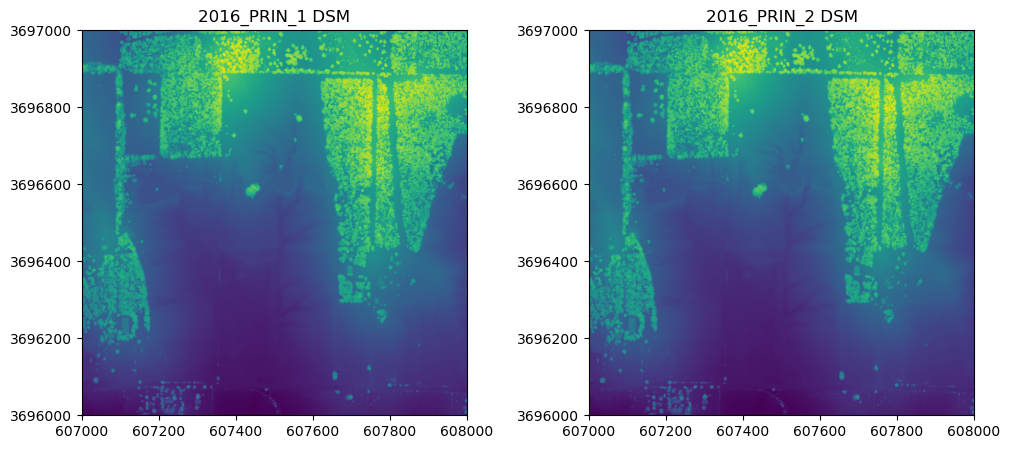

In [5]:
# Display the DSMs from the 1st and 2nd collections:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
show(dsm1_dataset, ax=ax1); ax1.ticklabel_format(style='plain'); ax1.set_title('2016_PRIN_1 DSM')
show(dsm2_dataset, ax=ax2); ax2.ticklabel_format(style='plain'); ax2.set_title('2016_PRIN_2 DSM');

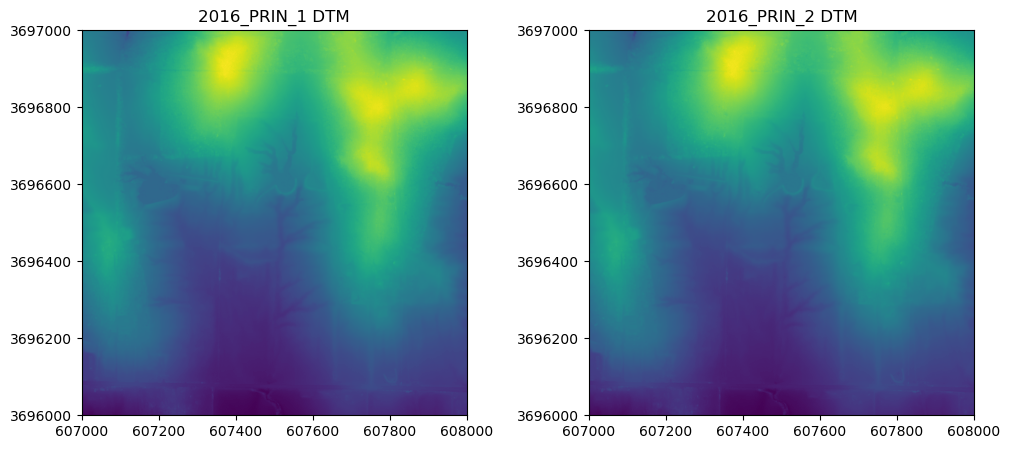

In [6]:
# Display the DTMs from the 1st and 2nd collections:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
show(dtm1_dataset, ax=ax1); ax1.ticklabel_format(style='plain'); ax1.set_title('2016_PRIN_1 DTM')
show(dtm2_dataset, ax=ax2); ax2.ticklabel_format(style='plain'); ax2.set_title('2016_PRIN_2 DTM');

Since we want to know what the changed between the two days, we will create an array containing the pixel differences across the two arrays.  To do this let's subtract the two DSMs. First let's extract the data from the datasets as follows:

In [7]:
dsm1_data = dsm1_dataset.read(1)
dsm2_data = dsm2_dataset.read(1)
diff_dsm_array = np.subtract(dsm1_data,dsm2_data)

Let's get some summary statistics for this DSM difference array. 

In [8]:
diff_dsm_array_mean = np.mean(diff_dsm_array)
diff_dsm_array_std = np.std(diff_dsm_array)
print('Mean difference in DSMs: ',round(diff_dsm_array_mean,3),'m')
print('Standard deviation of difference in DSMs: ',round(diff_dsm_array_std,3),'m')

Mean difference in DSMs:  0.019 m
Standard deviation of difference in DSMs:  0.743 m


The mean is close to zero (0.019 m), indicating there was very little systematic bias between the two days. However, we notice that the standard deviation of the data is quite high at 0.743 meters. Generally we expect NEON LiDAR data to have an error below 0.15 meters! Let's take a look at a histogram of the DSM difference. We use the flatten function on the 2D `diff_dsm_array` to convert it into a 1D array which allows the `hist()` function to run faster.

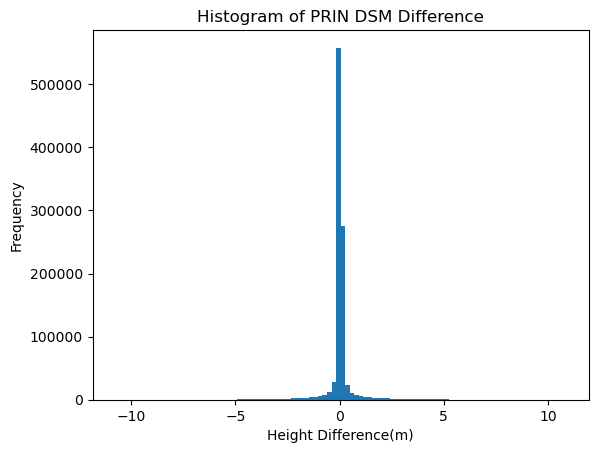

In [9]:
plt.figure()
plt.hist(diff_dsm_array.flatten(),100)
plt.title('Histogram of PRIN DSM Difference')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')
plt.show()

The histogram has long tails, obscuring the distribution near the center. To constrain the x-limits of the histogram we will use the mean and standard deviation just calculated. Since the data appears to be normally distributed, we can constrain the histogram to 95% of the data by including 2 standard deviations above and below the mean.   

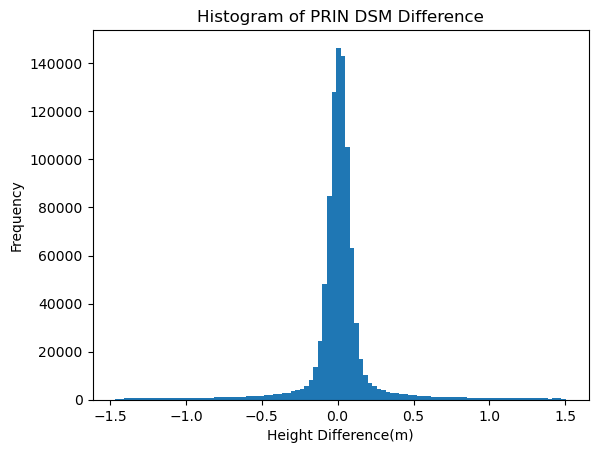

In [10]:
plt.figure()
plt.hist(diff_dsm_array.flatten(),100,range=[diff_dsm_array_mean-2*diff_dsm_array_std, diff_dsm_array_mean+2*diff_dsm_array_std]);
plt.title('Histogram of PRIN DSM Difference')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency')
plt.show()

The histogram shows a wide variation in DSM differences, with those at the 95% limit at around +/- 1.5 m. Let's take a look at the spatial distribution of the errors by plotting a map of the difference between the two DSMs. Here we'll also use the extra variable in the plot function to constrain the limits of the colorbar to 95% of the observations. 

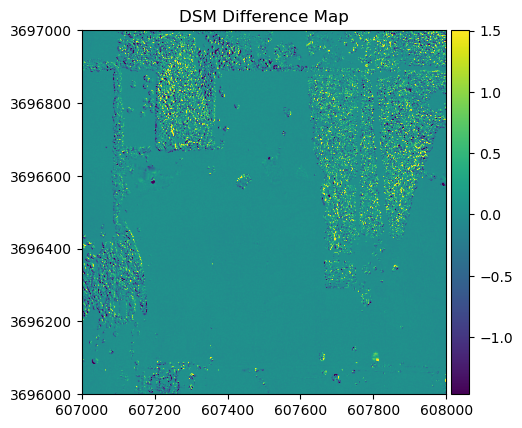

In [11]:
# define the min and max histogram values
dsm_diff_vmin = diff_dsm_array_mean-2*diff_dsm_array_std
dsm_diff_vmax = diff_dsm_array_mean+2*diff_dsm_array_std

# get the extent (bounds) from dsm1_dataset
left, bottom, right, top = dsm1_dataset.bounds
ext = [left, right, bottom, top]

# Plot, with some formatting to make it look nice
fig, ax = plt.subplots(1, 1, figsize=(5,6))
dsm_diff_map = show(diff_dsm_array,vmin=dsm_diff_vmin, vmax=dsm_diff_vmax, extent = ext, ax = ax, cmap='viridis')
im = dsm_diff_map.get_images()[0]
divider = make_axes_locatable(ax) 
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.ticklabel_format(style='plain'); # don't use scientific notation on the y-axis
ax.set_title('DSM Difference Map');

It seems that there is a spatial pattern in the distribution of errors. Now let's take a look at the statistics (mean, standard deviation), histogram and map for the difference in DTMs.

In [12]:
dtm1_data = dtm1_dataset.read(1)
dtm2_data = dtm2_dataset.read(1)
diff_dtm_array = np.subtract(dtm1_data,dtm2_data)

In [13]:
diff_dtm_array_mean = np.mean(diff_dtm_array)
diff_dtm_array_std = np.std(diff_dtm_array)
print('Mean difference in DTMs: ',round(diff_dtm_array_mean,3),'m')
print('Standard deviation of difference in DTMs: ',round(diff_dtm_array_std,3),'m')

Mean difference in DTMs:  0.014 m
Standard deviation of difference in DTMs:  0.102 m


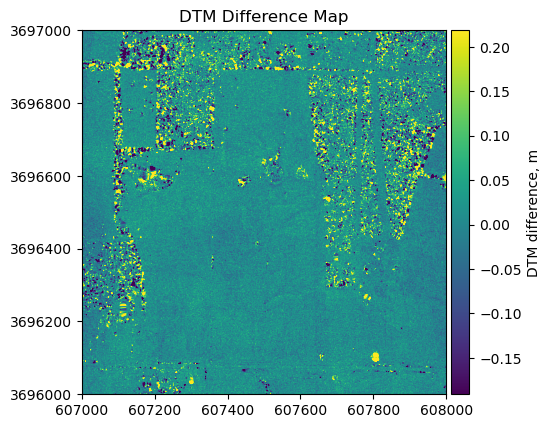

In [14]:
dtm_diff_vmin = diff_dtm_array_mean-2*diff_dtm_array_std
dtm_diff_vmax = diff_dtm_array_mean+2*diff_dtm_array_std

# Plot, with some formatting to make it look nice
fig, ax = plt.subplots(1, 1, figsize=(5,6))
dtm_diff_map = show(diff_dtm_array,vmin=dtm_diff_vmin, vmax=dtm_diff_vmax, extent = ext, ax = ax, cmap='viridis');
im = dtm_diff_map.get_images()[0]
divider = make_axes_locatable(ax) 
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.set_label('DTM difference, m')
ax.ticklabel_format(style='plain');
ax.set_title('DTM Difference Map');

The overall magnitude of differences are smaller than in the DSM but the same spatial pattern of the error is evident. 

Now, we'll plot the Canopy Height Model (CHM) of the same area. In the CHM, the tree heights above ground are represented, with all ground pixels having zero elevation. This time we'll use a colorbar which shows the ground as light green and the highest vegetation as dark green. We can set the lower limit of the color bar to zero and the upper limit to the mean canopy height to get a good color variation. 

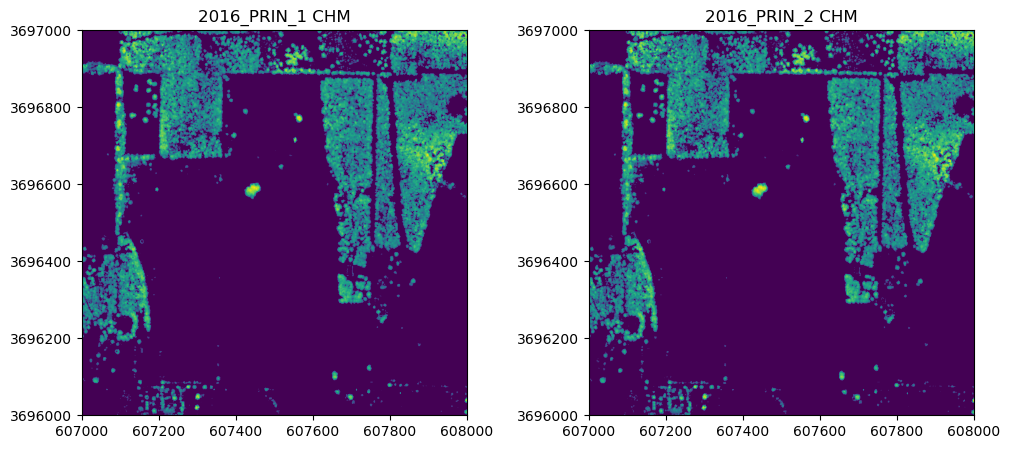

In [15]:
# Display the CHMs from the 1st and 2nd collections:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
show(chm1_dataset, ax=ax1); ax1.ticklabel_format(style='plain'); ax1.set_title('2016_PRIN_1 CHM')
show(chm2_dataset, ax=ax2); ax2.ticklabel_format(style='plain'); ax2.set_title('2016_PRIN_2 CHM');

From the CHM, it appears the spatial distribution of error patterns follow the location of vegetation. 

Now let's isolate only the pixels in the difference DSM that correspond to vegetation location, calcualte the mean and standard deviation and plot the associated histogram. Before displaying the histogram, we'll remove the no data values from the difference DSM and the non-zero pixels from the CHM. To keep the number of elements the same in each vector to allow element-wise logical operations in Python, we have to remove the difference DSM no data elements from the CHM array as well. 

In [16]:
chm1_data = chm1_dataset.read(1)
diff_dsm_array_veg_mean = np.nanmean(diff_dsm_array[chm1_data!=0.0])
diff_dsm_array_veg_std = np.nanstd(diff_dsm_array[chm1_data!=0.0])
print('Mean difference in DSMs on veg points: ',round(diff_dsm_array_veg_mean,3),'m')
print('Standard deviations of difference in DSMs on veg points: ',round(diff_dsm_array_veg_std,3),'m')

Mean difference in DSMs on veg points:  0.072 m
Standard deviations of difference in DSMs on veg points:  1.405 m


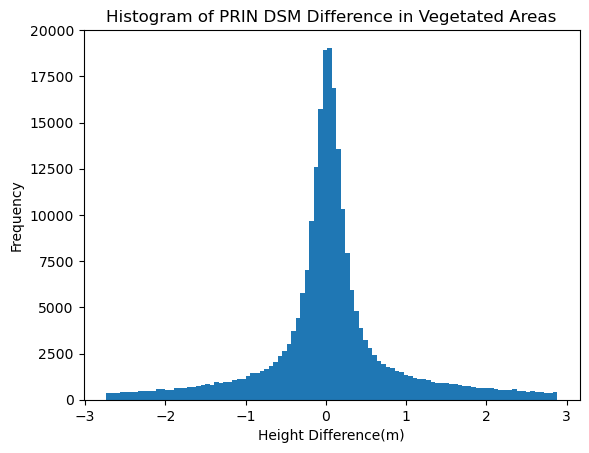

In [17]:
plt.figure();
diff_dsm_array_nodata_removed = diff_dsm_array[~np.isnan(diff_dsm_array)]
chm_dsm_nodata_removed = chm1_data[~np.isnan(diff_dsm_array)]

dsm_diff_veg_vmin = diff_dsm_array_veg_mean-2*diff_dsm_array_veg_std
dsm_diff_veg_vmax = diff_dsm_array_veg_mean+2*diff_dsm_array_veg_std

plt.hist(diff_dsm_array_nodata_removed[chm_dsm_nodata_removed!=0.0],100,range=[dsm_diff_veg_vmin, dsm_diff_veg_vmax])
plt.title('Histogram of PRIN DSM Difference in Vegetated Areas')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency');

The results show a similar mean difference of near zero, but an extremely high standard deviation of 1.381 m! Since the DSM represents the top of the tree canopy, this provides the level of uncertainty we can expect in the canopy height in forests characteristic of the PRIN site using NEON LiDAR data. 

Next we'll calculate the statistics and plot the histogram of the DTM vegetated areas

In [18]:
diff_dtm_array_veg_mean = np.nanmean(diff_dtm_array[chm1_data!=0.0])
diff_dtm_array_veg_std = np.nanstd(diff_dtm_array[chm1_data!=0.0])
print('Mean difference in DTMs on vegetated pixels: ',round(diff_dtm_array_veg_mean,3),'m')
print('Standard deviations of difference in DTMs on vegetated pixels: ',round(diff_dtm_array_veg_std,3),'m')

Mean difference in DTMs on vegetated pixels:  0.023 m
Standard deviations of difference in DTMs on vegetated pixels:  0.163 m


The mean difference is almost zero (0.023 m), and the variation in less than the DSM variation (0.163 m). 

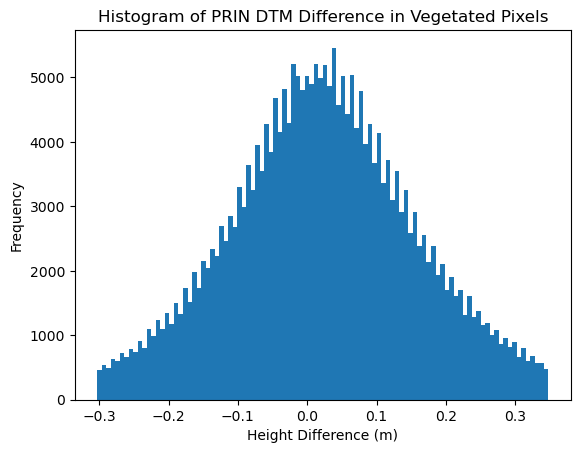

In [19]:
dtm_diff_veg_vmin = diff_dtm_array_veg_mean-2*diff_dtm_array_veg_std
dtm_diff_veg_vmax = diff_dtm_array_veg_mean+2*diff_dtm_array_veg_std

diff_dtm_array_nodata_removed = diff_dtm_array[~np.isnan(diff_dtm_array)] 
chm_dtm_nodata_removed = chm1_data[~np.isnan(diff_dtm_array)]
plt.hist((diff_dtm_array_nodata_removed[chm_dtm_nodata_removed!=0.0]),100,range=[dtm_diff_veg_vmin, dtm_diff_veg_vmax]);
plt.title('Histogram of PRIN DTM Difference in Vegetated Pixels');
plt.xlabel('Height Difference (m)'); plt.ylabel('Frequency');

Although the variation is reduced, it is still larger than expected for LiDAR. This is because under vegetation there may not be much laser energy reaching the ground, and those points that do may return with lower signal. The sparsity of points leads to surface interpolation over larger areas which can miss variations in the topography. Since the distribution of LIDAR and their location varied for each day, this resulted in different terrain representations and a uncertianty in the ground surface. This shows that the accuracy of LiDAR DTMs is reduced when under vegetation.

Finally, let's look at the DTM difference on only the ground points (where CHM = 0).

In [20]:
diff_dtm_array_ground_mean = np.nanmean(diff_dtm_array[chm1_data==0.0])
diff_dtm_array_ground_std = np.nanstd(diff_dtm_array[chm1_data==0.0])
print('Mean difference in DTMs on ground points: ',round(diff_dtm_array_ground_mean,3),'m')
print('Standard deviations of difference in DTMs on ground points: ',round(diff_dtm_array_ground_std,3),'m')

Mean difference in DTMs on ground points:  0.011 m
Standard deviations of difference in DTMs on ground points:  0.069 m


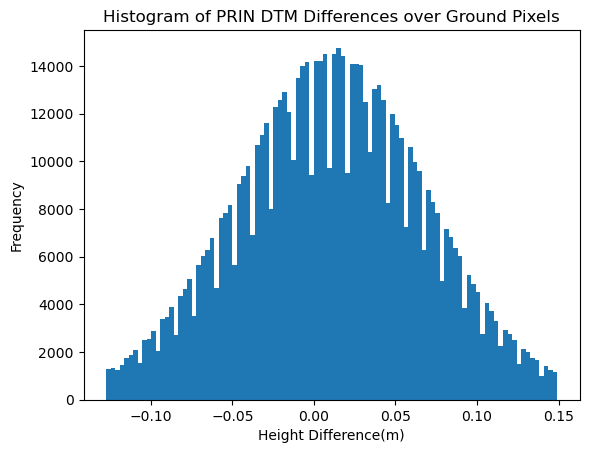

In [21]:
dtm_diff_gnd_vmin = diff_dtm_array_ground_mean-2*diff_dtm_array_ground_std
dtm_diff_gnd_vmax = diff_dtm_array_ground_mean+2*diff_dtm_array_ground_std

plt.hist((diff_dtm_array_nodata_removed[chm_dtm_nodata_removed==0.0]),100,range=[dtm_diff_gnd_vmin, dtm_diff_gnd_vmax])
plt.title('Histogram of PRIN DTM Differences over Ground Pixels')
plt.xlabel('Height Difference(m)'); plt.ylabel('Frequency');

In the open ground scenario we are able to produce the error chatracteristics we expect with a mean difference of only 0.011 m and a variation of 0.068 m. 

This shows that the uncertainty we expect in the NEON LiDAR system (~0.15 m) is only valid in bare, open, hard surface scenarios. We cannot expect the accuracy of the LiDAR to reach this level when vegetation is present. Quantifying the top of the canopy is particularly difficult and can lead to uncertainty in excess of 1 m for any given pixel.  